# Case Study 1 (Working file)

### Introduction

Knowing the location of business-critical machiney and/or workers is essential to optimize productivity for organizations that live and die by shipping times, workflow prioritization, deliverable timelines, and cost minimization. Real-time location systems (RTLS) have enabled some business to be in a position to monitor their assets through the production cycle. 

In this case study, we are evaluating the use of RTLS over wifi for an organization. Specifically, our authors (Nolan and Lang) posit that by distributing various wifi-enabled RTLS devices across the facility to assets, one might be able to use clustering methods to ascertain the predicted position of those assets based on past behavior. 

## Imports

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.cluster import KMeans 
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Create DataFrame

In [2]:
column_names = ['time', 'scanMac', 'posX', 'posY', 'posZ', 'orientation', 'mac', 'signal', 'channel', 'type']

lines = None
with open('../Data/offline.final.trace.txt', 'r') as file:
    lines = file.readlines()
    file.close()

instances = [] # will hold final data for dataframe

for line in lines:
    
    # strip "\n" from line
    line = line.rstrip('\n')
    
    # skip if comment
    if line[0] == '#':
        continue

    base = [] # [t, id, x, y, z, degree]
    rows = [] # base + [mac, signal, channel, type]

    for keyvalue in line.split(';'):
        key, value = keyvalue.split('=')

        if key in ['t', 'id', 'degree']:
            base.append(value)
        elif key == 'pos':
            # pos (x, y, z)
            base += value.split(',')
        else:
            # mac addresses and metrics (signal, channel, type)
            row = base.copy()
            row.append(key)
            row += value.split(',')
            rows.append(row)
    
    instances += rows

df = pd.DataFrame(instances, columns = column_names)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1181628 entries, 0 to 1181627
Data columns (total 10 columns):
time           1181628 non-null object
scanMac        1181628 non-null object
posX           1181628 non-null object
posY           1181628 non-null object
posZ           1181628 non-null object
orientation    1181628 non-null object
mac            1181628 non-null object
signal         1181628 non-null object
channel        1181628 non-null object
type           1181628 non-null object
dtypes: object(10)
memory usage: 90.2+ MB
None


,time,scanMac,posX,posY,posZ,orientation,mac,signal,channel,type
0,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,2437000000,3
1,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:90,-56,2427000000,3
2,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-53,2462000000,3
3,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8d,-65,2442000000,3
4,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:81,-65,2422000000,3


In [3]:
column_names = ['time', 'scanMac', 'posX', 'posY', 'posZ', 'orientation', 'mac', 'signal', 'channel', 'type']

lines = None
with open('../Data/online.final.trace.txt', 'r') as file:
    lines = file.readlines()
    file.close()

instances = [] # will hold final data for dataframe

for line in lines:
    
    # strip "\n" from line
    line = line.rstrip('\n')
    
    # skip if comment
    if line[0] == '#':
        continue

    base = [] # [t, id, x, y, z, degree]
    rows = [] # base + [mac, signal, channel, type]

    for keyvalue in line.split(';'):
        key, value = keyvalue.split('=')

        if key in ['t', 'id', 'degree']:
            base.append(value)
        elif key == 'pos':
            # pos (x, y, z)
            base += value.split(',')
        else:
            # mac addresses and metrics (signal, channel, type)
            row = base.copy()
            row.append(key)
            row += value.split(',')
            rows.append(row)
    
    instances += rows

df_online = pd.DataFrame(instances, columns = column_names)

print(df_online.info())
df_online.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53303 entries, 0 to 53302
Data columns (total 10 columns):
time           53303 non-null object
scanMac        53303 non-null object
posX           53303 non-null object
posY           53303 non-null object
posZ           53303 non-null object
orientation    53303 non-null object
mac            53303 non-null object
signal         53303 non-null object
channel        53303 non-null object
type           53303 non-null object
dtypes: object(10)
memory usage: 4.1+ MB
None


,time,scanMac,posX,posY,posZ,orientation,mac,signal,channel,type
0,1139692477303,00:02:2D:21:0F:33,0.0,0.05,0.0,130.5,00:14:bf:b1:97:8a,-43,2437000000,3
1,1139692477303,00:02:2D:21:0F:33,0.0,0.05,0.0,130.5,00:0f:a3:39:e1:c0,-52,2462000000,3
2,1139692477303,00:02:2D:21:0F:33,0.0,0.05,0.0,130.5,00:14:bf:3b:c7:c6,-62,2432000000,3
3,1139692477303,00:02:2D:21:0F:33,0.0,0.05,0.0,130.5,00:14:bf:b1:97:81,-58,2422000000,3
4,1139692477303,00:02:2D:21:0F:33,0.0,0.05,0.0,130.5,00:14:bf:b1:97:8d,-62,2442000000,3


## Exploratory Data Analysis (EDA)

In [4]:
df['mac'].value_counts()

00:0f:a3:39:e1:c0    145862
00:0f:a3:39:dd:cd    145619
00:14:bf:b1:97:8a    132962
00:14:bf:3b:c7:c6    126529
00:14:bf:b1:97:90    122315
00:14:bf:b1:97:8d    121325
00:14:bf:b1:97:81    120339
02:00:42:55:31:00    103887
02:64:fb:68:52:e6     50852
00:0f:a3:39:e0:4b     43508
02:2e:58:22:f1:ac     25112
00:0f:a3:39:e2:10     19162
02:37:fd:3b:54:b5      8732
02:b7:00:bb:a9:35      7602
02:5c:e0:50:49:de      6997
00:04:0e:5c:23:fc       418
00:30:bd:f8:7f:c5       301
00:e0:63:82:8b:a9       103
02:0a:3d:06:94:88         1
02:42:1c:4e:b5:c0         1
02:4f:99:43:30:cd         1
Name: mac, dtype: int64

In [5]:
# Drop MAC Ids that have a large abundance of nulls
rows_to_drop = ['02:64:fb:68:52:e6','00:0f:a3:39:e0:4b','02:2e:58:22:f1:ac','00:0f:a3:39:e2:10','02:37:fd:3b:54:b5','02:b7:00:bb:a9:35','02:5c:e0:50:49:de','00:04:0e:5c:23:fc','00:30:bd:f8:7f:c5','00:e0:63:82:8b:a9','02:42:1c:4e:b5:c0','02:0a:3d:06:94:88','02:4f:99:43:30:cd']

df = df[~df['mac'].str.contains('|'.join(rows_to_drop))]

In [6]:
# Drop additional rows with nulls
df = df.dropna()

In [7]:
df['mac'].value_counts()

00:0f:a3:39:e1:c0    145862
00:0f:a3:39:dd:cd    145619
00:14:bf:b1:97:8a    132962
00:14:bf:3b:c7:c6    126529
00:14:bf:b1:97:90    122315
00:14:bf:b1:97:8d    121325
00:14:bf:b1:97:81    120339
02:00:42:55:31:00    103887
Name: mac, dtype: int64

### Including MAC IDs ending C0 (and all others but excluding CD)

Weighted KNN appears to produce a better prediction against the test/train split OFFLINE data at .95 compared to .92 using the accuracy score and a k of 5.

In [8]:
# Withhold CD from DF
df = df[df['mac'].str[15:17] != 'cd']

In [9]:
# Sample 40% of rows
df = df.sample(frac=0.20)

In [10]:
df['mac'].value_counts()

00:0f:a3:39:e1:c0    29210
00:14:bf:b1:97:8a    26676
00:14:bf:3b:c7:c6    25130
00:14:bf:b1:97:90    24350
00:14:bf:b1:97:8d    24221
00:14:bf:b1:97:81    24129
02:00:42:55:31:00    20928
Name: mac, dtype: int64

In [11]:
#one hot encoding offline
cols_to_transform = ['mac','scanMac','channel']

df2 = pd.get_dummies(df, columns = cols_to_transform)

In [12]:
df2.dtypes

time                         object
posX                         object
posY                         object
posZ                         object
orientation                  object
signal                       object
type                         object
mac_00:0f:a3:39:e1:c0         uint8
mac_00:14:bf:3b:c7:c6         uint8
mac_00:14:bf:b1:97:81         uint8
mac_00:14:bf:b1:97:8a         uint8
mac_00:14:bf:b1:97:8d         uint8
mac_00:14:bf:b1:97:90         uint8
mac_02:00:42:55:31:00         uint8
scanMac_00:02:2D:21:0F:33     uint8
channel_2422000000            uint8
channel_2427000000            uint8
channel_2432000000            uint8
channel_2437000000            uint8
channel_2442000000            uint8
channel_2457000000            uint8
channel_2462000000            uint8
dtype: object

In [13]:
# Attributes vs. Label split - Offline data
x = df2.iloc[:, :-1].values
y = df2.iloc[:, 4].values

In [14]:
# Split into test / train on the offline data (assuming we cannot even see the online data)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

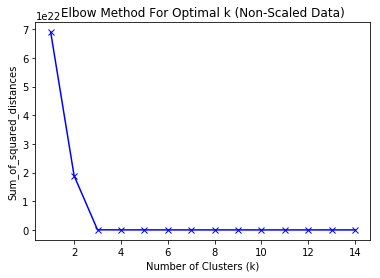

In [15]:
# Create elbow plot for sanity check on number of clusters - unscaled data
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df2)
    Sum_of_squared_distances.append(km.inertia_)
    
# Plot the appropriate k cluster size
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k (Non-Scaled Data)')
plt.show()

In [16]:
# Scale the data - offline
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


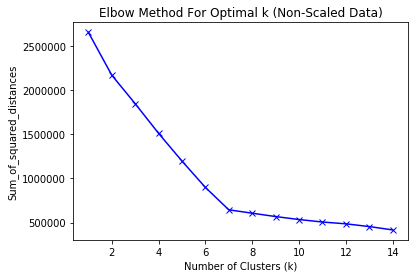

In [18]:
# Create elbow plot for sanity check on number of clusters - scaled data
# Optimal K = 11?
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_train)
    Sum_of_squared_distances.append(km.inertia_)
    
# Plot the appropriate k cluster size
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k (Non-Scaled Data)')
plt.show()

In [19]:
# Create KNN plot - unweighted
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [20]:
y_pred = classifier.predict(X_test)

In [21]:
# Confusion matrix results - avg. precision = .84 / .92  | avg. recall = .83 / .92  |  accuracy = .92
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[364   4   2 ...   0   0   0]
 [  5 369  10 ...   0   0   0]
 [  1   1 363 ...   0   0   0]
 ...
 [  0   0   0 ...  28   0   0]
 [  0   0   0 ...   0  22   0]
 [  0   0   0 ...   0   0  51]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94       385
         0.1       0.92      0.92      0.92       401
         0.2       0.93      0.95      0.94       381
         0.3       0.92      0.92      0.92       533
         0.4       0.94      0.91      0.93       418
         0.5       0.95      0.93      0.94       270
         0.6       0.94      0.97      0.95       218
         0.7       0.96      0.93      0.94       344
         0.8       0.89      0.91      0.90        75
         0.9       0.91      0.90      0.91        71
         1.0       1.00      0.91      0.95        44
         1.2       0.98      0.93      0.95        43
         1.5       0.90      0.94      0.92       176
       134.2       0.87      0.96      0.91        83
       134.3       0.91      0.91      0.91        54
       134.4       0.93      0.91      0.92        82
       134.5       0.95      0.88      0.92       112
       134.6       0.93    

In [22]:
# Checking the K assumption and plotting all possible K values from 1-40 to see which yields the best mean error rate
error = []

# Calculating error for K values between 1 and 20
for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

In [ ]:
# Plot K - mean error is lowest around k between 0-10

plt.figure(figsize=(12, 6))
plt.plot(range(1, 20), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate (K)')
plt.xlabel('K')
plt.ylabel('Mean Error')

In [23]:
# Create KNN plot - weighted
classifier = KNeighborsClassifier(n_neighbors=5, weights = 'distance')
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')

In [24]:
y_pred = classifier.predict(X_test)

In [33]:
# Confusion matrix results - precision .87 / .95  |  accuracy .86 / .95  |  accuracy .95
confusion_matrix(y_test, y_pred)
#print(classification_report(y_test, y_pred))

array([[373,   1,   1, ...,   0,   0,   0],
       [  5, 378,   4, ...,   0,   0,   0],
       [  0,   0, 373, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  28,   0,   0],
       [  0,   0,   0, ...,   0,  23,   0],
       [  0,   0,   0, ...,   0,   0,  55]])

In [26]:
error = []

# Calculating error for K values between 1 and 20
for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

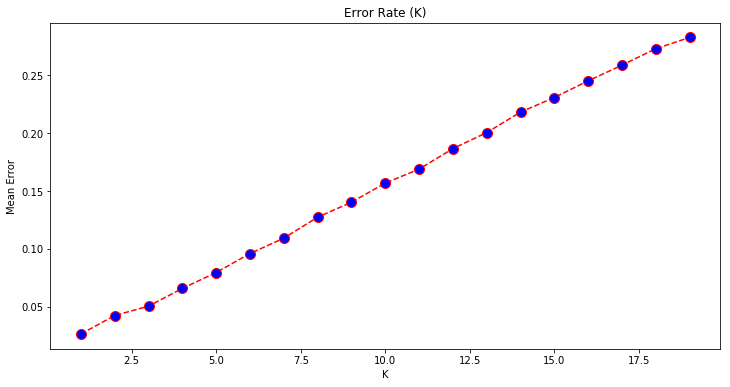

In [27]:
# Plot K

plt.figure(figsize=(12, 6))
plt.plot(range(1, 20), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate (K)')
plt.xlabel('K')
plt.ylabel('Mean Error')